In [4]:
#import pyarrow.feather as feather
import pandas as pd
import numpy as np
#from scipy.io import netcdf
import matplotlib.pyplot as plt 
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [5]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [6]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        try:
            new_columns.append(pd.to_datetime(col).date())
        except: new_columns.append(col)
    return new_columns

In [7]:
# import freq df
k=3
freq_level =  pd.read_csv(f"dataset/modeling/sample{k}/freq_sample.csv").set_index("proj_id")
print(freq_level.shape)
print(" ")
print("details: ")
print(f"daily_freq: {freq_level[freq_level['daily']].shape}")
print(f"mid_weekly_freq: {freq_level[freq_level['mid_weekly']].shape}")
print(f"weekly_freq: {freq_level[freq_level['weekly']].shape}")
print(f"fortnight_freq: {freq_level[freq_level['fortnight']].shape}")
print(f"low_freq_freq: {freq_level[freq_level['low_freq']].shape}")

freq_level

(25, 7)
 
details: 
daily_freq: (5, 7)
mid_weekly_freq: (5, 7)
weekly_freq: (5, 7)
fortnight_freq: (5, 7)
low_freq_freq: (5, 7)


,daily,mid_weekly,weekly,fortnight,low_freq,length,freq
proj_id,,,,,,,
NW_110200469,True,False,False,False,False,1356,1
MV_20480008,True,False,False,False,False,2058,1
BB_31519239,True,False,False,False,False,3770,1
NI_200000700,True,False,False,False,False,4659,1
BY_11163,True,False,False,False,False,5962,1
BY_6166,False,True,False,False,False,114,4
NW_80303572,False,True,False,False,False,1203,4
BE_9092,False,True,False,False,False,1771,4
MV_25440602,False,True,False,False,False,2393,4


In [8]:
# import t s and convert into date type
grouped_t_s = pd.read_csv(f"dataset/modeling/sample{k}/sample_t_s.csv").set_index("proj_id")
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
# drop colmns after 2011.11.30 bcs not existing in temp and prec
grouped_t_s= grouped_t_s.drop(grouped_t_s.columns[-33:-2],axis=1)
print(grouped_t_s.shape)
grouped_t_s.head()

(25, 6515)


,length,freq,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,...,2012-10-21,2012-10-22,2012-10-23,2012-10-24,2012-10-25,2012-10-26,2012-10-27,2012-10-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
NW_110200469,1356,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.31000,78.30000
MV_20480008,2058,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.04000,2.04000,2.04000,2.05000,2.07000,2.05000,2.05000,2.04000,2.03000,2.01000
BB_31519239,3770,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.11000,2.12000,2.13000,2.12000,NaN,NaN
NI_200000700,4659,1,44.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43.77000,43.77000,43.76000,43.76000,43.76000,43.76000,43.76000,43.76000,43.73000,43.73000
BY_11163,5962,1,NaN,373.08399,NaN,NaN,NaN,NaN,NaN,NaN,...,370.42552,370.41246,370.39952,370.41767,370.44612,370.48885,370.56146,370.48608,370.57969,370.52173


In [9]:
# import ave_temp 
ave_temp = pd.read_csv(f"dataset/modeling/sample{k}/sample_temp.csv").set_index("proj_id")
ave_temp.columns = convert_col_to_date(ave_temp.columns)
print(ave_temp.shape)
ave_temp.head()


(25, 6546)


,length,freq,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
NW_110200469,1356,1,9.0,9.0,-10.0,-58.0,-66.0,-57.0,-76.0,-36.0,...,53.0,80.0,60.0,72.0,104.0,64.0,73.0,38.0,32.0,4.0
MV_20480008,2058,1,17.0,2.0,-13.0,-41.0,-57.0,-67.0,-65.0,-55.0,...,50.0,61.0,40.0,47.0,60.0,68.0,64.0,47.0,47.0,22.0
BB_31519239,3770,1,24.0,-1.0,-12.0,-61.0,-55.0,-77.0,-54.0,-51.0,...,42.0,58.0,29.0,57.0,68.0,61.0,69.0,52.0,44.0,26.0
NI_200000700,4659,1,11.0,7.0,-20.0,-74.0,-77.0,-70.0,-75.0,-37.0,...,45.0,77.0,56.0,53.0,96.0,70.0,68.0,35.0,32.0,12.0
BY_11163,5962,1,2.0,-24.0,-41.0,-98.0,-124.0,-105.0,-100.0,-72.0,...,22.0,35.0,44.0,35.0,64.0,68.0,62.0,50.0,6.0,-10.0


In [10]:
# import the cum_prec 
cum_prec=pd.read_csv(f"dataset/modeling/sample{k}/sample_prec.csv").set_index("proj_id")
cum_prec.columns = convert_col_to_date(cum_prec.columns)
print(cum_prec.shape)
cum_prec.head()

(25, 6546)


,length,freq,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
NW_110200469,1356,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,26.0,19.0,1.0,28.0,2.0,0.0,1.0,2.0
MV_20480008,2058,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,8.0,5.0,2.0,28.0,1.0,9.0,53.0,0.0
BB_31519239,3770,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,22.0,13.0,4.0,6.0,12.0,68.0,164.0,3.0
NI_200000700,4659,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,26.0,31.0,1.0,34.0,0.0,0.0,0.0,8.0
BY_11163,5962,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,176.0,155.0,2.0


In [8]:
#######################################################################################

# Func

In [11]:
# create df for a t s (one row in grouped_t_s df)
def create_one_ts_df(row):
    bgr = row.name
    idx = row.dropna().index[2:]
    ts = row[idx]
    temp = ave_temp[idx].loc[bgr]
    prec = cum_prec[idx].loc[bgr]
    df = pd.DataFrame({"ts":ts,"temp": temp,"prec":prec, })
    return df
####################################################################

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
##################################################################################

def split_df(reframed, n_lag, n_features):
    # split into train and test sets
    values = reframed.values
    n_train = int(len(reframed)*0.8)
    train = values[:n_train, :]
    test = values[n_train:, :]
    # split into input and outputs
    n_obs = n_lag * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
    return train_X, train_y, test_X, test_y



# pick t s

In [12]:
# apply the func
ts1 = grouped_t_s.iloc[4]
df = create_one_ts_df(ts1)
print(df.shape)

(5900, 3)


Text(0.5, 1.0, 'prec')

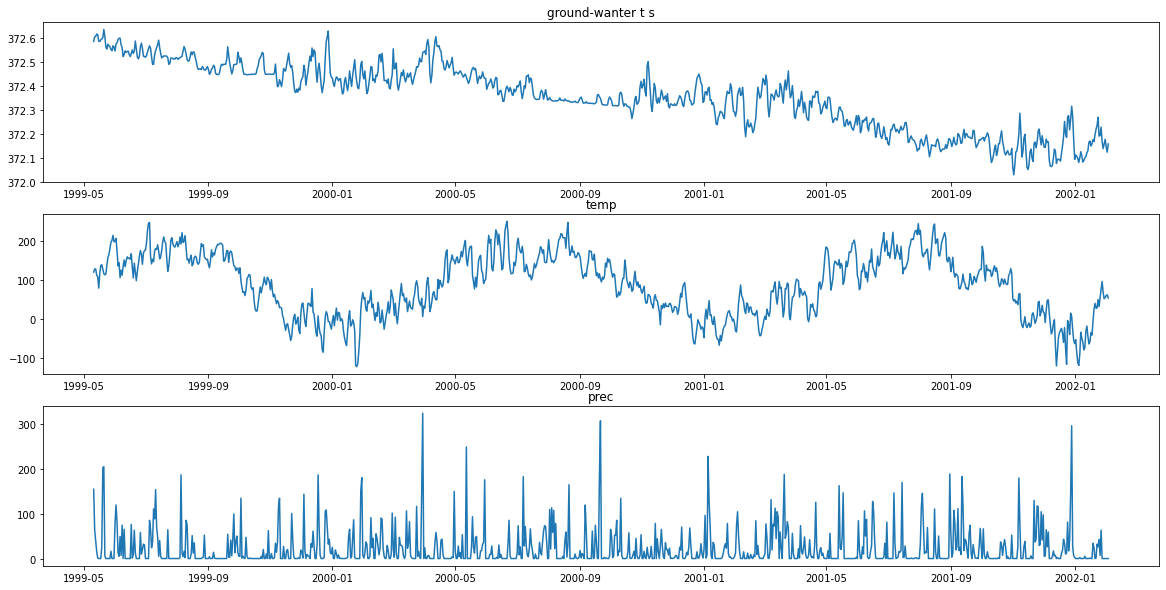

In [17]:
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 1000,2000
axs[0].plot(df["ts"][a:b])
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')

# apply

(5890, 33)
(4712, 20) 4712 (4712,)
input to be 3D [samples, timesteps(lag, features]

train: (4712, 10, 2) , (4712,) ,test: (1178, 10, 2) , (1178,)
Epoch 1/50
66/66 - 3s - loss: 0.1571 - val_loss: 0.1195
Epoch 2/50
66/66 - 1s - loss: 0.1354 - val_loss: 0.1116
Epoch 3/50
66/66 - 1s - loss: 0.1355 - val_loss: 0.1092
Epoch 4/50
66/66 - 0s - loss: 0.1277 - val_loss: 0.1055
Epoch 5/50
66/66 - 1s - loss: 0.1208 - val_loss: 0.1020
Epoch 6/50
66/66 - 0s - loss: 0.1134 - val_loss: 0.0950
Epoch 7/50
66/66 - 1s - loss: 0.1047 - val_loss: 0.0927
Epoch 8/50
66/66 - 0s - loss: 0.0951 - val_loss: 0.0867
Epoch 9/50
66/66 - 1s - loss: 0.0879 - val_loss: 0.0834
Epoch 10/50
66/66 - 0s - loss: 0.0816 - val_loss: 0.0816
Epoch 11/50
66/66 - 1s - loss: 0.0779 - val_loss: 0.0810
Epoch 12/50
66/66 - 0s - loss: 0.0759 - val_loss: 0.0805
Epoch 13/50
66/66 - 0s - loss: 0.0749 - val_loss: 0.0801
Epoch 14/50
66/66 - 1s - loss: 0.0744 - val_loss: 0.0799
Epoch 15/50
66/66 - 0s - loss: 0.0740 - val_loss: 0.0797
Epoch 

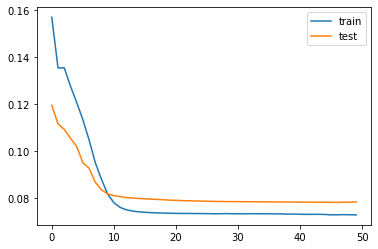

Test RMSE: 0.267


In [18]:
#######################################################

# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_lag = 10 
n_features = 2
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, 1)
print(reframed.shape)
####################################################################


train_X, train_y, test_X, test_y= split_df(reframed, n_lag, n_features)
print("input to be 3D [samples, timesteps(lag, features]\n")
print(f"train: {train_X.shape} , {train_y.shape} ,test: {test_X.shape} , {test_y.shape}")
#################################################################################


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
#################################################################################################


# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_lag*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -2:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -2:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
########################################################################################



# lag =10

## there is a mistake !!!!

<AxesSubplot:>

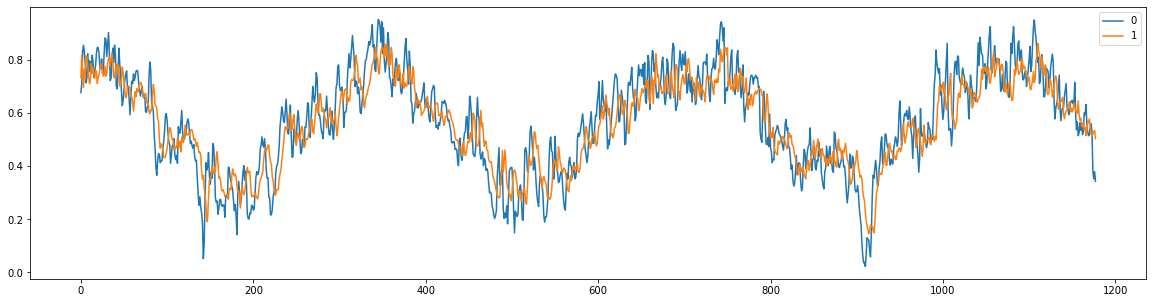

In [19]:
fd = pd.DataFrame([test_y.T[0], yhat.T[0]]).T

fd.plot(figsize=(20,5))

In [ ]:
#################################looooooop

In [ ]:
err = []
for i in range(0,25):
    ts = grouped_t_s.iloc[i]
    inv_yhat, inv_y, rmse = modeling_n_lag(ts)
    err.append(rmse)
    
# plot yhat and ytest
plt.bar(range(0,len(err)-17), err[:-17])


In [ ]:
print(f"rmse: {round(rmse,3)}")
fd = pd.DataFrame([inv_y, inv_yhat]).T
fd.plot(figsize=(20,5))